# Generating Human Faces using GANs

### Project Objective
The objective of this project is to generate human faces using Generative Adversarial Networks (GANs). The aim is to create a model that can generate realistic human faces that look like actual photographs. 

### Data Type 
The dataset used for this project is the `CelebA dataset` from Kaggle. It is a large-scale face attribute dataset with more than 200,000 celebrity images, each annotated with 40 attributes such as hair style, gender, and age. The data type is in the form of RGB image files.

### Problem Type
The problem addressed in this project is `generative modeling`, specifically image generation. The goal is to create a model that can learn the underlying patterns in the input dataset and generate new images that closely resemble the original images. This is achieved by training a GAN model, which consists of a generator and a discriminator network, to generate high-quality, realistic images of human faces. 

### Libraries

In [2]:
import os
import torch
import random
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from torch.utils.data import DataLoader,Dataset
import torchvision.transforms as T
from torchvision.utils import make_grid,save_image
import matplotlib.pyplot as plt
from PIL import Image
from tqdm.notebook import tqdm
import opendatasets as od
import cv2
import imageio.v2 as imageio

### Hyperparameters
Here, we are setting different hyperparameters that will be used during the training process of Generative Adversarial Networks (GANs) for generating fake human faces. 

**Image_size:** It is the size to which the input images will be resized before feeding into the model. The larger image size may capture more details about the features of an object in the image. But, it also needs higher computational power and longer training time. In contrast, smaller image size requires lesser computational power and less training time but may capture fewer details about the object. 

**Batch_size:** It refers to the number of input images processed at once by the model during each iteration of training. A larger batch size provides more stable updates to the model parameters and helps the model converge faster with better generalization performance. However, a smaller batch size uses less GPU memory, and it does not have problems with convergence instability due to overfitting or poor conditioning.

**Latent_size:** It is the dimensionality of the input noise vector that is fed as input to the generator network. A higher latent size may capture more complex relationships between the input noise and output image. However, this also makes the model more complex and harder to train, requiring more training time and computational resources.

**lr (Learning rate):** A higher learning rate might make the model converge faster, but it may make the model unstable and result in overshooting the optimal values. A lower learning rate may result in slow convergence and getting stuck in local minima.

**Epochs:** One epoch means one complete pass through the entire dataset. Increasing the number of epochs may lead to better results, but it may also result in overfitting on the training data. A lower number of epochs will lead to faster training but may not give the best results.

In [2]:
# Setting the hyperparameters for GANs training

image_size = 64         # The size of the image to which the input will be resized
batch_size = 1024       # The batch size of input images to be used in each iteration during training.
latent_size = 256       # The dimension of the latent space, i.e., the input to the generator network which is a random noise vector.
lr = 0.0002
epochs = 10

### Downloading the Dataset
Downloaded from: https://www.kaggle.com/datasets/jessicali9530/celeba-dataset

**About CelebFaces Attributes (CelebA) Dataset:**
The CelebA dataset is a large-scale face attributes dataset consisting of over 200K celebrity images with annotations. It contains 40 binary attribute annotations per image which includes facial features such as hair color, gender, age, and other facial components. Along with these attributes, it also contains landmark points that define the facial boundaries and attribute region masks that indicate the location of facial attributes in the image. The dataset is released by the Multimedia Laboratory, The Chinese University of Hong Kong. 

We have downloaded the dataset using the `opendatasets` library from the Kaggle website where it's publicly available. 

In [3]:
dataset_url = 'https://www.kaggle.com/datasets/jessicali9530/celeba-dataset'
od.download(dataset_url)

Skipping, found downloaded files in "./celeba-dataset" (use force=True to force download)


### Exploring the Dataset
Here, we are counting the total number of images present in the CelebA Dataset

In [4]:
# Define the path for the directory where the data is stored
data_dir = './celeba-dataset/img_align_celeba/img_align_celeba/'

# Display the total number of images present in the dataset
print("Total Images: ",len(os.listdir(data_dir)))

# Get a list of all image files present in the dataset directory
image_files = os.listdir(data_dir)

Total Images:  202599


Let us pick some random images and check their shapes

Image Shape:  (218, 178, 3)


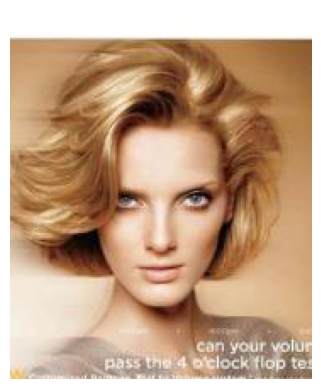

In [5]:
# checking shape of a some random image
img = Image.open(data_dir + random.choice(image_files))
print("Image Shape: ",np.array(img).shape)         
plt.axis('off')
plt.imshow(img)      

Image Shape:  (218, 178, 3)


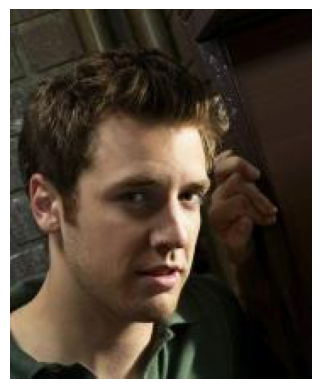

In [6]:
# checking shape of a some random image
img = Image.open(data_dir + random.choice(image_files))
print("Image Shape: ",np.array(img).shape)         
plt.axis('off')
plt.imshow(img)      

Hence, we can see that images are of shape 218 x 178 pixels and have 3 channels so its a RGB image

### Creating Custom Pytorch Dataset

The `__init__` method initializes the attributes of the dataset. Here, it takes two arguments: `data_dir` and `transform`. `data_dir` specifies the directory path from which images will be loaded, and `transform` is an optional argument for preprocessing the images. The method first stores these arguments as attributes of the object (`self.data_dir` and `self.transform`) for later use.

Next, the method gets a list of all image filenames in the `data_dir` directory using the `os.listdir()` function. These filenames are stored as a list in the `self.image_files` attribute. Additionally, it assigns a fixed label of 0 to all the images in the `self.labels` attribute. This is because the purpose of this custom PyTorch dataset is not to perform any classification task, but rather to simply load and preprocess a set of images. By assigning a fixed label of 0 to all images, we are essentially saying that these images belong to the same class or category. 

The `__getitem__` method loads and preprocesses an image based on the given `index` value. It first gets the filepath of the image using `os.path.join()`. Then, it uses the `Image.open()` function from the Pillow library to load the image and converts it to RGB format using `convert('RGB')`. 

If a `transform` argument was provided in the `__init__` method, it applies all the transforms defined in the provided transform object on the image.

Finally, the method returns a tuple containing the preprocessed image and its corresponding label from `self.labels`.

The `__len__` method simply returns the length (total number) of images in the dataset based on the length of `image_files`.


In [7]:
class CustomCelebDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.transform = transform
        
        # Get a list of all image filenames in the directory
        self.image_files = os.listdir(data_dir)
        
        # Assign a fixed label (0) to all images
        self.labels = [0] * len(self.image_files)
        
    def __getitem__(self, index):
        # Load and preprocess the image
        img_path = os.path.join(self.data_dir, self.image_files[index])
        img = Image.open(img_path).convert('RGB')
        if self.transform is not None:
            img = self.transform(img)
            
        # Return the preprocessed image and its label
        return img, self.labels[index]
    
    def __len__(self):
        return len(self.image_files)

### Data Augmentations and Dataloader
Here, we apply some Data Augmentations and prepare the Pytorch Dataloader for the Custom Pytorch Dataset we created above

Since the input image has dimensions of 218 x 178 and `image_size` is set to 128, the transformations applied to the dataset using `T.Compose`, along with their effects on the input image shapes, are as follows:

1. `T.Resize(image_size)` - Resizes each input image to the given `image_size` of 128x128 pixels. The shape of each image after this transformation will be (128, 128).

2. `T.CenterCrop(image_size)` - Applies a center crop to the resized image so that it remains square with side length equal to `image_size`. Since the input images were already resized to the given `image_size`, this transformation will not change their shape.

3. `T.ToTensor()` - Converts each image from a NumPy array or Pillow object into a PyTorch tensor. The shape of each image after this transformation will be (3, 128, 128), where 3 represents the number of channels (RGB) and 128x128 represent the width and height, respectively.

4. `T.Normalize(*stats)` - Normalizes the pixel values of each image using the given mean and standard deviation values (in this case, `(0.5, 0.5, 0.5)` for both mean and standard deviation). This will ensure that pixel values are in the range `(-1, 1)`, which is more  convenient for training the discriminator. 

Once the dataset has been defined and transformed, it is passed to a data loader `train_dl` using the `DataLoader` class. This sets up the loader to iterate over batches of the dataset during training, with each batch having a size of `batch_size`. The loader shuffles the data at the beginning of each epoch using `shuffle=True` and uses up to 8 worker processes (`num_workers=8`) for data loading to speed up the process. Finally, we set `pin_memory` to True to enable faster data transfer between CPU and GPU.


In [8]:
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)
train_ds = CustomCelebDataset(data_dir, transform=T.Compose([
    T.Resize(image_size),                           # 128x128
    T.CenterCrop(image_size),                       # 128x128
    T.ToTensor(),                                   # 3 x 128 x 128
    T.Normalize(*stats)]))

train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=8, pin_memory=True)

### Helper Functions- Creating Batches
Here, we will create some helper functions that will be helpful ahead:  

- `denorm()` - This function is used to denormalize the image tensors by reversing the normalization process that was applied to these images earlier. The function takes in a tensor of normalized images and applies the following formula to return the denormalized version:
    
    `denorm_img_tensors = img_tensors * std_dev + mean`

   Here, `stats` is a tuple of two tensors representing the mean and standard deviation values calculated from the training set of images. Thus, the function adjusts each pixel in the input image tensor using these statistics to convert it back to its original form.

- `show_images()` - This function displays a grid of up to nmax images passed as a tensor, with each image consisting of three color channels. It converts a tensor of image data into a single image grid that can be visualized using the Matplotlib library's `imshow` function.


In [9]:
# To Denormalize the images
def denorm(img_tensors):                            
    return img_tensors * stats[1][0] + stats[0][0]

# To show images
def show_images(images, nmax):       
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))

def show_batch(dl, nmax):
    for images, _ in dl:
        show_images(images, nmax)
        print("Shape of each batch:",images.shape)  # (batch_size, channels, height, width)
        break

Shape of each batch: torch.Size([1024, 3, 64, 64])


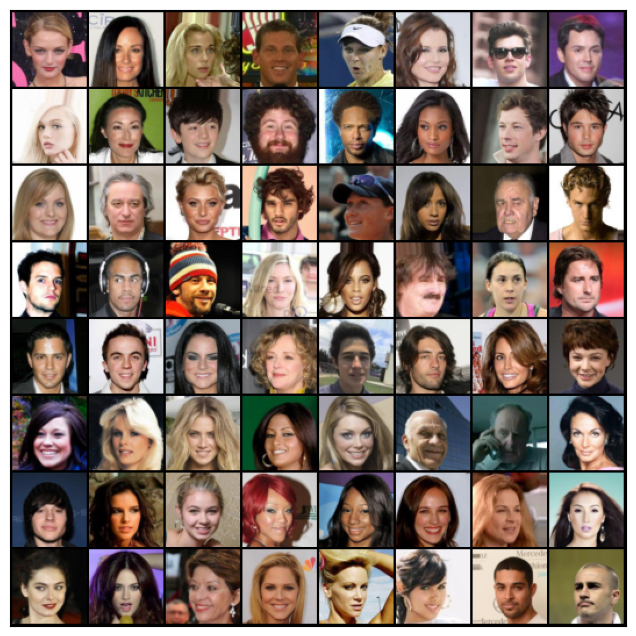

In [10]:
show_batch(train_dl,nmax = 64)

### Using GPU
The following cell makes the model run on GPU (if available). GPU trains the model faster. We can use a [Graphics Processing Unit](https://en.wikipedia.org/wiki/Graphics_processing_unit) (GPU) to train our models faster if our execution platform is connected to a GPU manufactured by NVIDIA. We can follow these instructions to use a GPU on the platform of choice:

* _Google Colab_: Use the menu option "Runtime > Change Runtime Type" and select "GPU" from the "Hardware Accelerator" dropdown.
* _Kaggle_: In the "Settings" section of the sidebar, select "GPU" from the "Accelerator" dropdown. Use the button on the top-right to open the sidebar.
* _Binder_: Notebooks running on Binder cannot use a GPU, as the machines powering Binder aren't connected to any GPUs.
* _Linux_: If your laptop/desktop has an NVIDIA GPU (graphics card), make sure you have installed the [NVIDIA CUDA drivers](https://docs.nvidia.com/cuda/cuda-installation-guide-linux/index.html).
* _Windows_: If your laptop/desktop has an NVIDIA GPU (graphics card), make sure you have installed the [NVIDIA CUDA drivers](https://docs.nvidia.com/cuda/cuda-installation-guide-microsoft-windows/index.html).
* _macOS_: macOS is not compatible with NVIDIA GPUs


If GPU is not available the code still runs fine on CPU but will take more time. 

In [11]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

The `DeviceDataLoader` class is a data loader that wraps around a PyTorch dataloader to move the inputs and targets to a specified device (GPU). It has three methods: 

- `__init__(self, dl, device)`: Initializes the `DeviceDataLoader` object with a dataloader `dl` and a device `device`.

- `__iter__(self)`: Iterates through each batch of data in the wrapped dataloader `dl`, moves the data to the specified device using the `to_device()` function, and yields the data.

- `__len__(self)`: Returns the number of batches in the wrapped dataloader `dl`. This is used by PyTorch's training loop to determine the number of iterations in each epoch.

In [12]:
class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

Checking default device, if it returns `device(type='cuda)` that means we are using GPU

In [13]:
device = get_default_device()
device

device(type='cuda')

Moving Dataloader to device(GPU) 

In [14]:
train_dl = DeviceDataLoader(train_dl, device)

### Generative Modelling
<div style="text-align: center;">
  <div style="background-color: white; display: inline-block;">
    <img src="https://i.imgur.com/6NMdO9u.png" alt="image" width="420"/>
  </div>
</div>

In GANs, there are two neural networks: a *Generator* and a *Discriminator*. The generator generates a "fake" sample given a random vector/matrix, and the discriminator attempts to detect whether a given sample is "real" (picked from the training data) or "fake" (generated by the generator). Training happens in tandem: we train the discriminator for a few epochs, then train the generator for a few epochs, and repeat. This way both the generator and the discriminator get better at doing their jobs




### Discriminator Model
The discriminator takes an image as input, and tries to classify it as "real" or "generated". In this sense, it's like any other neural network. We'll use a convolutional neural networks (CNN) which outputs a single number output for every image. We'll use stride of 2 to progressively reduce the size of the output feature map.

![](https://github.com/vdumoulin/conv_arithmetic/raw/master/gif/padding_strides_odd.gif)

The formulas relating the output shape of the convolution to the input shape are:
    
$$n_H = \Bigl\lfloor \frac{n_{H_{prev}} - f + 2 \times pad}{stride} \Bigr\rfloor +1$$
$$n_W = \Bigl\lfloor \frac{n_{W_{prev}} - f + 2 \times pad}{stride} \Bigr\rfloor +1$$
$$n_C = \text{number of filters used in the convolution}$$

- $n_H$, $n_W$ and $n_C$ denote respectively the height, width and number of channels of a given layer. 
- $n_{H_{prev}}$, $n_{W_{prev}}$ and $n_{C_{prev}}$ denote respectively the height, width and number of channels of the previous layer.
- $f$ dentoes filter size

Here's an overview of the architecture of the discriminator model we are using:

- Input: The input is an RGB image with dimensions 3 x 128 x 128.

- Layer 1: A convolutional layer with 64 filters, a kernel size of 3, a stride of 2, and no padding. This is followed by batch normalization and a leaky ReLU activation function with a negative slope of 0.2. The output shape is 64 x 63 x 63.

- Layer 2: Another convolutional layer with 128 filters, a kernel size of 4, a stride of 2, and padding of 1. This is also followed by batch normalization and a leaky ReLU activation function. The output shape is 128 x 31 x 31.

- Layer 3: A third convolutional layer with 256 filters, a kernel size of 4, a stride of 2, and padding of 1. Again, this is followed by batch normalization and a leaky ReLU activation function. The output shape is 256 x 15 x 15.

- Layer 4: A fourth convolutional layer with 512 filters, a kernel size of 4, a stride of 2, and padding of 1. Batch normalization and a leaky ReLU activation function are applied again. The output shape is 512 x 7 x 7.

- Layer 5: A fifth convolutional layer with 1024 filters, a kernel size of 4, a stride of 2, and padding of 1. Batch normalization and a leaky ReLU activation function are applied again. The output shape is 1024 x 3 x 3.

- Layer 6: A final convolutional layer with a single filter, a kernel size of 3, a stride of 1, and no padding. This is the only layer without batch normalization or a leaky ReLU activation function. The output shape is 1 x 1 x 1.

- Flattening: To go from a tensor to a scalar output, we flatten the output of the last convolutional layer into a one-dimensional array with 1024 elements using the `nn.Flatten()` module.

- Output: Finally, we apply a sigmoid activation function to squash the output value between 0 and 1.

Overall, this discriminator model has a total of 6 convolutional layers, each followed by batch normalization and a leaky ReLU activation function (except for the last layer). The output of the last convolutional layer is flattened and passed through a sigmoid activation function to produce the final discriminative output.

In [15]:
discriminator = nn.Sequential(  
    # in: 3 x 64 x 64

    nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False), 
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),       
    # out: 64 x 32 x 32

    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 128 x 16 x 16

    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 256 x 8 x 8

    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 512 x 4 x 4

    nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
    # out: 1 x 1 x 1    

    nn.Flatten(),
    nn.Sigmoid()
)   

Moving Discriminator Model to device(GPU)

In [16]:
discriminator = to_device(discriminator, device)

### Generator Model
The input to the generator is typically a vector or a matrix of random numbers (referred to as a latent tensor) which is used as a seed for generating an image. The generator model architecture is a deep neural network that takes a noise vector of size `latent_size` as input and generates an image of size 3 x 128 x 128. To achive this, we'll use the `ConvTranspose2d` layer from PyTorch, which is performs to as a *transposed convolution* (also referred to as a *deconvolution*).

![](https://i.imgur.com/DRvK546.gif)
 
Here's an overview of the architecture of the discriminator model we are using:

1. `nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False)` - This layer is a transposed convolutional layer that takes in the noise vector and outputs an activation volume of size 512 x 4 x 4. The kernel size is 4 x 4 with a stride of 1 and no padding. The output size is calculated using the formula `out_size = (input_size - 1) * stride - 2*padding + kernel_size`.

2. `nn.BatchNorm2d(512)` - This is a batch normalization layer that normalizes the activations of the previous layer across the batch dimension.

3. `nn.ReLU(True)` - This is a rectified linear unit activation function that applies element-wise non-linearity to the activations from the previous layer.

4. `nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False)` - This layer is similar to the first layer except it has fewer output channels and a stride of 2, which causes the activation volume to be upsampled by a factor of 2. The output size is 256 x 8 x 8.

5. `nn.BatchNorm2d(256)` and `nn.ReLU(True)` - These layers perform batch normalization and ReLU activation on the activations produced by the previous layer, respectively.

6. `nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False)` - This layer further upsamples the activation volume by a factor of 2 and decreases the number of output channels to 128. The output size is 128 x 16 x 16.

7. `nn.BatchNorm2d(128)` and `nn.ReLU(True)` - These layers are similar to the ones before and perform batch normalization and ReLU activation, respectively.

8. `nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False)` - This layer upsamples the activation volume by a factor of 2 again and decreases the number of output channels to 64. The output size is 64 x 32 x 32.

9. `nn.BatchNorm2d(64)` and `nn.ReLU(True)` - These layers are the same as the previous ones and perform batch normalization and ReLU activation.

10. `nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1, bias=False)` - This layer upsamples the activation volume by a factor of 2 and decreases the number of output channels further to 32. The output size is 32 x 64 x 64.

11. `nn.BatchNorm2d(32)` and `nn.ReLU(True)` - These layers perform batch normalization and ReLU activation on the activations produced by the previous layer.

12. `nn.ConvTranspose2d(32, 3, kernel_size=4, stride=2, padding=1, bias=False)` - This layer is the final transposed convolutional layer that outputs an image of size 3 x 128 x 128. The output size is calculated using the formula mentioned before.

13. `nn.Tanh()` - This layer applies the hyperbolic tangent activation function which squashes the pixel values to the range (-1, 1) to produce the final image.

The generator model architecture consists of a series of transposed convolutional layers that progressively upsample the activation volume while reducing the number of output channels, followed by batch normalization and ReLU activation. The final output layer applies a Tanh activation to produce the final image.

In [17]:
generator = nn.Sequential(
    # in: latent_size x 1 x 1

    nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    # out: 512 x 4 x 4

    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    # out: 256 x 8 x 8

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # out: 128 x 16 x 16

    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    # out: 64 x 32 x 32

    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()       
    # out: 3 x 64 x 64 
)

Moving Generator Model to device(GPU)

In [18]:
generator = to_device(generator, device)

### Training Discriminator Model

Since the discriminator is a binary classification model, we can use the binary cross entropy loss function to quantify how well it is able to differentiate between real and generated images.

- First, the gradients of the Discriminator are cleared using `opt_d.zero_grad()`, where `opt_d` is the optimizer used to update the Discriminator's weights.
- Real images are passed through the Discriminator, and the output is compared with a tensor of ones (`real_targets`) using binary cross-entropy loss (`F.binary_cross_entropy`). 
- The loss for the real images is calculated as `real_loss`.
- Similarly, fake images are generated by passing random noise through the Generator network, and these fake images are passed through the Discriminator network. The output is compared with a tensor of zeros (`fake_targets`) using binary cross-entropy loss (`F.binary_cross_entropy`).
- The loss for the fake images is calculated as `fake_loss`.
- The total loss for the Discriminator is calculated as the sum of `real_loss` and `fake_loss`.
- The gradients of the Discriminator are computed with respect to its weights using `loss.backward()`.
- The optimizer is updated using `opt_d.step()`.

The `real_score` and `fake_score` are evaluation metrics. These represent the average output of the Discriminator on the real and fake images, respectively. During training, we want the `real_score` to be close to 1, indicating that the Discriminator can accurately classify real images. We also want the `fake_score` to be close to 0, indicating that the Discriminator can accurately classify fake images. 

Finally, we return `loss.item()`, `real_score`, and `fake_score`. These values will be used to monitor the performance of the Discriminator during training.

In [19]:
def train_discriminator(real_images, opt_d):
    # Clear discriminator gradients
    opt_d.zero_grad()

    # Pass real images through discriminator
    real_preds = discriminator(real_images) # u get 128 numbers in range (0,1)
    real_targets = torch.ones(real_images.size(0), 1, device=device) # targets = 1 for real images   
    real_loss = F.binary_cross_entropy(real_preds, real_targets) 
    real_score = torch.mean(real_preds).item() # evaluation metric, we want real_score~1
    
    # Generate fake images from a batch of latent tensors
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)

    # Pass fake images through discriminator
    fake_targets = torch.zeros(fake_images.size(0), 1, device=device)   # targets = 0 for fake images
    fake_preds = discriminator(fake_images)
    fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)
    fake_score = torch.mean(fake_preds).item()  # evaluation metric, we fake_score~0

    # Update discriminator weights
    loss = real_loss + fake_loss
    loss.backward()         # compute grad w.r.t weights of discriminator
    opt_d.step()            # optimiser of discriminator          
    return loss.item(), real_score, fake_score

### Training Generator Model
Now we train the Generator network by generating fake images and trying to fool the Discriminator. The objective is to train the Generator to generate images that are indistinguishable from real images.

- First, the gradients of the Generator are cleared using `opt_g.zero_grad()`, where `opt_g` is the optimizer used to update the Generator's weights.
-  Fake images are generated by passing random noise through the Generator network (`generator(latent)`).
- These fake images are passed through the Discriminator network, and the output is compared with a tensor of ones (`targets`) using binary cross-entropy loss (`F.binary_cross_entropy`).
- The total loss for the Generator is calculated as `loss`.
- The gradients of the Generator are computed with respect to its weights using `loss.backward()`.
- The optimizer is updated using `opt_g.step()`.

During training, the objective of the Generator is to minimize the binary cross-entropy loss between the Discriminator's prediction of the fake images and a tensor of ones (`targets`). This encourages the Generator to generate images that are similar to real images, and hence it tries to "fool" the Discriminator into thinking that the fake images are real.

Finally, we return `loss.item()`. This value will be used to monitor the performance of the Generator during training.
Note that: 
- We want discriminator to be part of loss function for generator.
- We calculate the loss by setting the target labels to 1 i.e. real. We do this because the generator's objective is to "fool" the discriminator.

In [20]:
def train_generator(opt_g):
    # Clear generator gradients
    opt_g.zero_grad()
    
    # Generate fake images by generating a batch of random latent tensors using torch.randn
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)
    
    # Try to fool the discriminator
    preds = discriminator(fake_images)
    targets = torch.ones(batch_size, 1, device=device) # VIP step to fool discriminator
    loss = F.binary_cross_entropy(preds, targets)
    
    # Update generator weights
    loss.backward() # calculate grads w.r.t parameters of generator
    opt_g.step()
    
    return loss.item()

Let's create a directory where we can save intermediate outputs from the generator to visually inspect the progress of the model. We'll also create a helper function to export the generated images. as There is no validation set here

The function `save_samples()` is defined that takes in an index (to keep track of the generated image), latent tensors (inputs to the generator), and a boolean flag 'show' (whether or not to display the generated images).

Inside the function, the generator model takes in the latent tensors to produce fake images. These images are then normalized and saved as a PNG file with a name based on the given index using `save_image()`. The function also displays the fake images if the 'show' flag is set to True.

Saving generated-images-0000.png


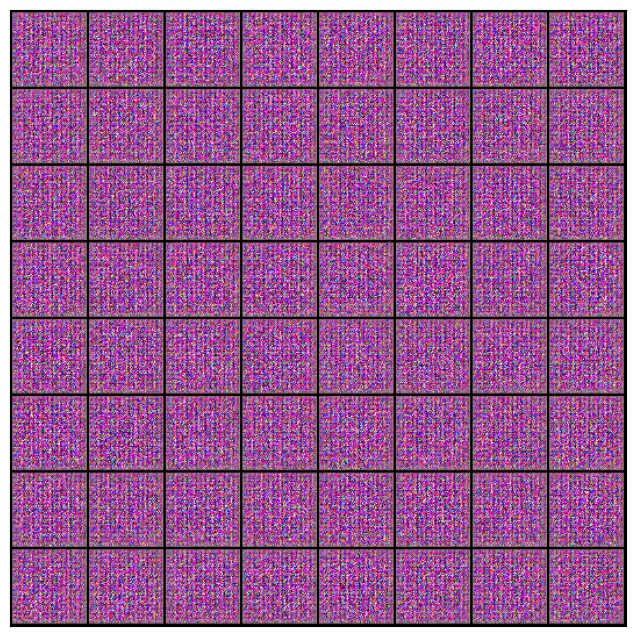

In [21]:
def save_samples(index, latent_tensors, show=True):
    gen_dir = 'generated'
    os.makedirs(gen_dir, exist_ok=True)
    fake_images = generator(latent_tensors)
    fake_images = denorm(fake_images)
    fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
    save_image(fake_images, os.path.join(gen_dir, fake_fname), nrow=8)
    print('Saving', fake_fname)
    if show:
        _, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))

fixed_latent = torch.randn(64, latent_size, 1, 1, device=device)
save_samples(0, fixed_latent)

### Training Loop
- We are now ready to train the model. The `fit` function is a training loop for the GAN that trains the generator and discriminator models. 

The function takes in the number of epochs to train for, learning rate (lr), and a start index (for naming checkpoint files). It initializes lists to store losses and scores for the generator and discriminator, creates optimizer objects for both models using the Adam optimizer, and loads a checkpoint if it exists (to resume training from a previous point).

The training loop runs for each epoch, iterating through batches of real images from a data loader. For each batch, the discriminator is trained with `train_discriminator()`, which calculates the loss for both real and fake images, and updates the discriminator's weights. Then the generator is trained with `train_generator()`, which calculates the loss for the generator based on the discriminator's feedback, and updates the generator's weights.

The function also records and logs the losses and scores for each epoch, saves generated images at the end of each epoch, and saves a checkpoint of the models and optimizers at the end of each epoch. The checkpoint allows the training to be resumed from where it left off if the process was interrupted or needs to continue at a later time.

At the end of the training, we return the lists of losses and scores for both models.

In [33]:
def fit(epochs, lr, start_idx=1):
    torch.cuda.empty_cache()  # we get fresh memory of GPU
    
    # Losses & scores
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []
    
    # Create optimizers
    opt_d = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
    opt_g = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))

    # Load checkpoint if it exists
    if os.path.exists("checkpoint.pt"):
        print("Loading last saved checkpoint...")
        checkpoint = torch.load("checkpoint.pt")
        generator.load_state_dict(checkpoint["generator_state_dict"])
        discriminator.load_state_dict(checkpoint["discriminator_state_dict"])
        opt_g.load_state_dict(checkpoint["opt_g_state_dict"])
        opt_d.load_state_dict(checkpoint["opt_d_state_dict"])
        losses_g += checkpoint["losses_g"]
        losses_d += checkpoint["losses_d"]
        real_scores += checkpoint["real_scores"]
        fake_scores += checkpoint["fake_scores"]
        start_epoch = checkpoint["epoch"]
    else:
        start_epoch = 0

    # Training Loop
    for epoch in range(start_epoch, epochs):
        for real_images, _ in tqdm(train_dl):       # where to put tqdm
            # Train discriminator
            loss_d, real_score, fake_score = train_discriminator(real_images, opt_d)
            # Train generator
            loss_g = train_generator(opt_g)
            
        # Record losses & scores
        losses_g.append(loss_g)
        losses_d.append(loss_d)
        real_scores.append(real_score)
        fake_scores.append(fake_score)
        
        # Log losses & scores (last batch)
        print("Epoch [{}/{}], gen_Loss: {:.4f}, dis_Loss: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1, epochs, loss_g, loss_d, real_score, fake_score))
    
        # Save generated images
        save_samples(epoch+start_idx, fixed_latent, show=False)

        # Save checkpoint
        checkpoint = {
            "epoch": epoch + 1,
            "generator_state_dict": generator.state_dict(),
            "discriminator_state_dict": discriminator.state_dict(),
            "opt_g_state_dict": opt_g.state_dict(),
            "opt_d_state_dict": opt_d.state_dict(),
            "losses_g": losses_g,
            "losses_d": losses_d,
            "real_scores": real_scores,
            "fake_scores": fake_scores
        }
        torch.save(checkpoint, "checkpoint.pt")
        print("Saving checkpoint...")
    
    return losses_g, losses_d, real_scores, fake_scores

Let us train the model for few epochs now and check the generated images

In [83]:
history = fit(epochs, lr)   # 10 epochs, lr = 0.0002

  0%|          | 0/198 [00:00<?, ?it/s]

Epoch [1/10], gen_Loss: 2.5309, dis_Loss: 0.4466, real_score: 0.7553, fake_score: 0.1238
Saving generated-images-0001.png
Saving checkpoint...


  0%|          | 0/198 [00:00<?, ?it/s]

Epoch [2/10], gen_Loss: 3.6696, dis_Loss: 0.3189, real_score: 0.9293, fake_score: 0.1940
Saving generated-images-0002.png
Saving checkpoint...


  0%|          | 0/198 [00:00<?, ?it/s]

Epoch [3/10], gen_Loss: 6.4771, dis_Loss: 0.4549, real_score: 0.9268, fake_score: 0.2910
Saving generated-images-0003.png
Saving checkpoint...


  0%|          | 0/198 [00:00<?, ?it/s]

Epoch [4/10], gen_Loss: 2.4922, dis_Loss: 0.6300, real_score: 0.6030, fake_score: 0.0256
Saving generated-images-0004.png
Saving checkpoint...


  0%|          | 0/198 [00:00<?, ?it/s]

Epoch [5/10], gen_Loss: 1.8734, dis_Loss: 0.5874, real_score: 0.6471, fake_score: 0.0872
Saving generated-images-0005.png
Saving checkpoint...


  0%|          | 0/198 [00:00<?, ?it/s]

Epoch [6/10], gen_Loss: 2.7744, dis_Loss: 0.4933, real_score: 0.7834, fake_score: 0.1948
Saving generated-images-0006.png
Saving checkpoint...


  0%|          | 0/198 [00:00<?, ?it/s]

Epoch [7/10], gen_Loss: 3.8270, dis_Loss: 0.4934, real_score: 0.8729, fake_score: 0.2778
Saving generated-images-0007.png
Saving checkpoint...


  0%|          | 0/198 [00:00<?, ?it/s]

Epoch [8/10], gen_Loss: 8.3355, dis_Loss: 1.7771, real_score: 0.9933, fake_score: 0.7817
Saving generated-images-0008.png
Saving checkpoint...


  0%|          | 0/198 [00:00<?, ?it/s]

Epoch [9/10], gen_Loss: 2.6578, dis_Loss: 0.2988, real_score: 0.8510, fake_score: 0.1165
Saving generated-images-0009.png
Saving checkpoint...


  0%|          | 0/198 [00:00<?, ?it/s]

Epoch [10/10], gen_Loss: 5.7852, dis_Loss: 0.6586, real_score: 0.9638, fake_score: 0.4234
Saving generated-images-0010.png
Saving checkpoint...


Let us check the last generated image after these few epochs

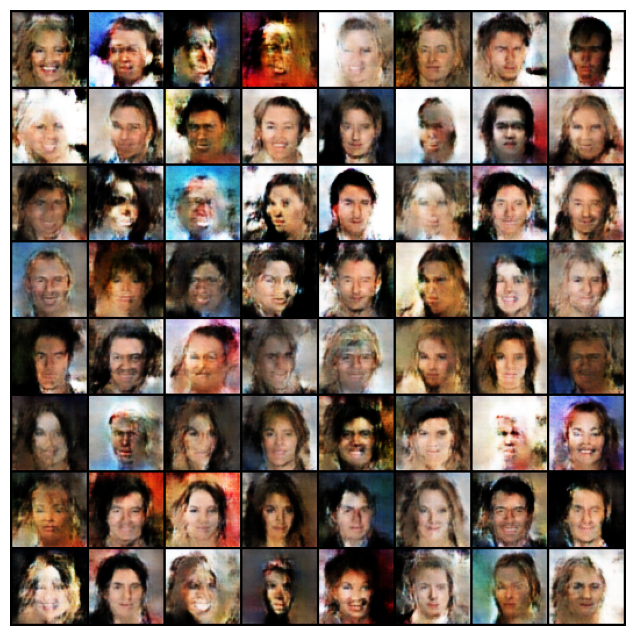

In [31]:
# Show Last Generated Image
last_img = Image.open('./generated/'+sorted(os.listdir('./generated/'))[-1])
plt.figure(figsize=(8, 8))
plt.axis('off')
plt.imshow(last_img) 
plt.show()

Looks somewhat good!, let us train the model for more epochs now. Let us now keep epochs=30. Note that model will now run for 20 more epochs as it was trained for 10 epochs earlier.

In [36]:
epochs = 30                 # 20 more epochs
history = fit(epochs, lr)       

Loading last saved checkpoint...


  0%|          | 0/198 [00:00<?, ?it/s]

Epoch [11/30], gen_Loss: 3.6657, dis_Loss: 0.1135, real_score: 0.9439, fake_score: 0.0510
Saving generated-images-0011.png
Saving checkpoint...


  0%|          | 0/198 [00:00<?, ?it/s]

Epoch [12/30], gen_Loss: 2.8237, dis_Loss: 0.5118, real_score: 0.8100, fake_score: 0.2340
Saving generated-images-0012.png
Saving checkpoint...


  0%|          | 0/198 [00:00<?, ?it/s]

Epoch [13/30], gen_Loss: 2.6975, dis_Loss: 0.2590, real_score: 0.8363, fake_score: 0.0621
Saving generated-images-0013.png
Saving checkpoint...


  0%|          | 0/198 [00:00<?, ?it/s]

Epoch [14/30], gen_Loss: 4.2539, dis_Loss: 0.1810, real_score: 0.9507, fake_score: 0.1171
Saving generated-images-0014.png
Saving checkpoint...


  0%|          | 0/198 [00:00<?, ?it/s]

Epoch [15/30], gen_Loss: 2.7786, dis_Loss: 0.3346, real_score: 0.8112, fake_score: 0.0991
Saving generated-images-0015.png
Saving checkpoint...


  0%|          | 0/198 [00:00<?, ?it/s]

Epoch [16/30], gen_Loss: 4.0838, dis_Loss: 0.2355, real_score: 0.9554, fake_score: 0.1629
Saving generated-images-0016.png
Saving checkpoint...


  0%|          | 0/198 [00:00<?, ?it/s]

Epoch [17/30], gen_Loss: 3.5273, dis_Loss: 0.1558, real_score: 0.9489, fake_score: 0.0941
Saving generated-images-0017.png
Saving checkpoint...


  0%|          | 0/198 [00:00<?, ?it/s]

Epoch [18/30], gen_Loss: 3.7793, dis_Loss: 0.2368, real_score: 0.9042, fake_score: 0.1184
Saving generated-images-0018.png
Saving checkpoint...


  0%|          | 0/198 [00:00<?, ?it/s]

Epoch [19/30], gen_Loss: 3.2556, dis_Loss: 0.1975, real_score: 0.8808, fake_score: 0.0594
Saving generated-images-0019.png
Saving checkpoint...


  0%|          | 0/198 [00:00<?, ?it/s]

Epoch [20/30], gen_Loss: 5.6152, dis_Loss: 0.8287, real_score: 0.9632, fake_score: 0.4990
Saving generated-images-0020.png
Saving checkpoint...


  0%|          | 0/198 [00:00<?, ?it/s]

Epoch [21/30], gen_Loss: 4.5605, dis_Loss: 0.4572, real_score: 0.9372, fake_score: 0.2975
Saving generated-images-0021.png
Saving checkpoint...


  0%|          | 0/198 [00:00<?, ?it/s]

Epoch [22/30], gen_Loss: 3.3956, dis_Loss: 0.3413, real_score: 0.8979, fake_score: 0.1920
Saving generated-images-0022.png
Saving checkpoint...


  0%|          | 0/198 [00:00<?, ?it/s]

Epoch [23/30], gen_Loss: 2.1450, dis_Loss: 0.5681, real_score: 0.6807, fake_score: 0.1157
Saving generated-images-0023.png
Saving checkpoint...


  0%|          | 0/198 [00:00<?, ?it/s]

Epoch [24/30], gen_Loss: 2.5727, dis_Loss: 0.2380, real_score: 0.8079, fake_score: 0.0037
Saving generated-images-0024.png
Saving checkpoint...


  0%|          | 0/198 [00:00<?, ?it/s]

Epoch [25/30], gen_Loss: 4.5952, dis_Loss: 0.3128, real_score: 0.9413, fake_score: 0.2053
Saving generated-images-0025.png
Saving checkpoint...


  0%|          | 0/198 [00:00<?, ?it/s]

Epoch [26/30], gen_Loss: 4.2621, dis_Loss: 0.2096, real_score: 0.9417, fake_score: 0.1298
Saving generated-images-0026.png
Saving checkpoint...


  0%|          | 0/198 [00:00<?, ?it/s]

Epoch [27/30], gen_Loss: 3.0434, dis_Loss: 0.1932, real_score: 0.8876, fake_score: 0.0636
Saving generated-images-0027.png
Saving checkpoint...


  0%|          | 0/198 [00:00<?, ?it/s]

Epoch [28/30], gen_Loss: 3.8588, dis_Loss: 0.6303, real_score: 0.9333, fake_score: 0.3770
Saving generated-images-0028.png
Saving checkpoint...


  0%|          | 0/198 [00:00<?, ?it/s]

Epoch [29/30], gen_Loss: 4.3365, dis_Loss: 0.2879, real_score: 0.9737, fake_score: 0.2130
Saving generated-images-0029.png
Saving checkpoint...


  0%|          | 0/198 [00:00<?, ?it/s]

Epoch [30/30], gen_Loss: 5.0531, dis_Loss: 0.3465, real_score: 0.9674, fake_score: 0.2444
Saving generated-images-0030.png
Saving checkpoint...


### Results
Let us check the last generated image now

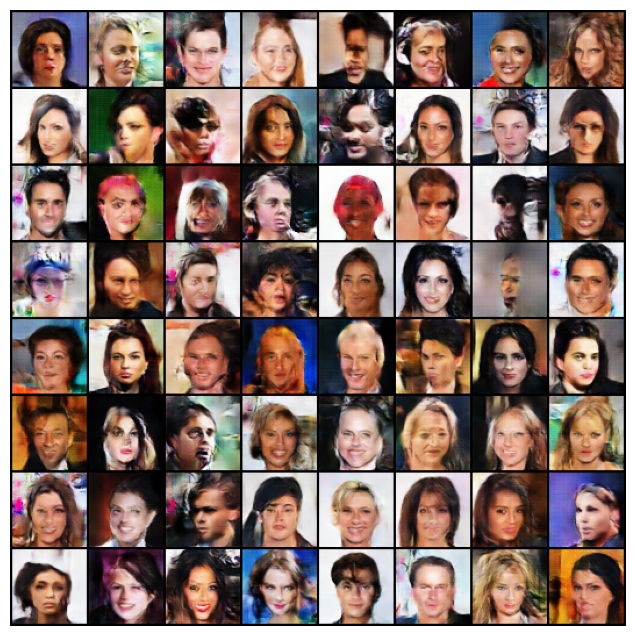

In [43]:
# Show Last Generated Image
last_img = Image.open('./generated/'+sorted(os.listdir('./generated/'))[-1])
plt.figure(figsize=(8, 8))
plt.axis('off')
plt.imshow(last_img) 
plt.show()

Hence we can see that the quality of the generated images has improved a lot after 20 more epochs. With just 30 epochs, we can see that the model has learned to generate images of human faces fairly well. We can further train the model for more epochs to get even better results.

### Plotting losses & scores
Visualizing losses is quite useful for debugging the training process. For GANs, we expect the generator's loss to reduce over time, without the discriminator's loss getting too high.

In [39]:
losses_g, losses_d, real_scores, fake_scores = history

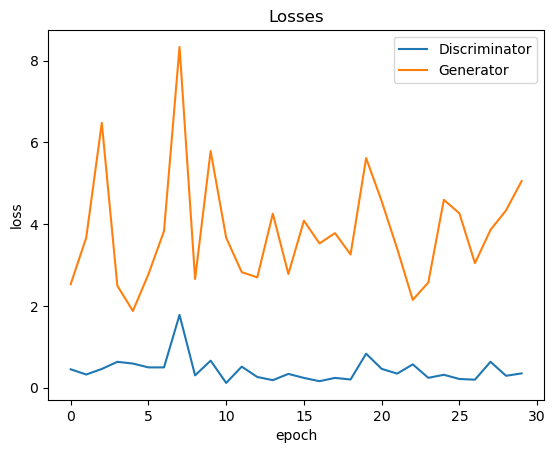

In [40]:
plt.plot(losses_d, '-')
plt.plot(losses_g, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');

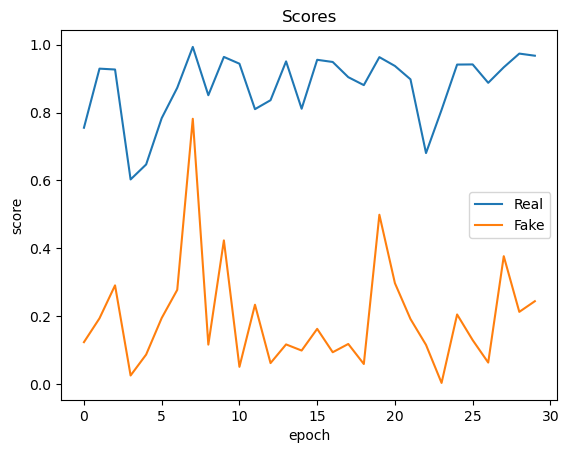

In [41]:
plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real', 'Fake'])
plt.title('Scores');

### Generating GIF
Let us visualize the training process by combining the sample images generated after each epoch into a GIF using Imagio

In [5]:
# Set up file paths and variables
img_dir = './generated/'
duration = 1000

# Sort image files by filename
files = [os.path.join(img_dir, f) for f in os.listdir(img_dir) if 'generated' in f]
files.sort()

# Create GIF from images
images = [imageio.imread(fname) for fname in files]
imageio.mimsave('fake_faces.gif', images, duration=duration)

Note that GIF may loop once, in that case reload the notebook

In [6]:
# Display GIF
HTML('<img src="fake_faces.gif">')

### References
- https://jovian.ai/aakashns/06b-anime-dcgan
- https://www.coursera.org/learn/convolutional-neural-networks